In [2]:
import pandas as pd
import numpy as np

from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
transactions = pd.read_csv('transactions.csv')

In [4]:
transactions.amount = transactions.amount.apply(lambda x: round(x/11.2296))

In [5]:
train_transactions = transactions[transactions.amount < 0].copy()
train_transactions['day'] = train_transactions.tr_datetime.apply(lambda dt: dt.split()[0]).astype(int)

In [6]:
transactions.groupby("mcc_code").count().sort_values("amount", ascending = False).tail(10)

,customer_id,tr_datetime,tr_type,amount,term_id
mcc_code,,,,,
8699,67,67,67,67,35
9402,67,67,67,67,48
7531,65,65,65,65,36
7629,63,63,63,63,32
3351,60,60,60,60,34
7829,54,54,54,54,24
2741,53,53,53,53,26
5697,47,47,47,47,31
8244,41,41,41,41,18


* 6010, 6011 - снятие налички;
* 5411 - супермаркеты
* 4814 - звонки
* 4829 - переводы

In [7]:
train_transactions.head()

,customer_id,tr_datetime,mcc_code,tr_type,amount,term_id,day
0,39026145,0 10:23:26,4814,1030,-200.0,NaN,0
2,39026145,1 10:20:56,4829,2330,-5000.0,NaN,1
3,39026145,1 10:39:54,5499,1010,-124.0,NaN,1
4,39026145,2 15:33:42,5499,1010,-82.0,NaN,2
5,39026145,2 15:53:49,5541,1010,-1304.0,NaN,2


In [8]:
test_transactions = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                                 index=np.arange(1, 31) + train_transactions.day.max())
test_transactions = test_transactions.unstack().reset_index().dropna(axis=1)
test_transactions.columns = ['mcc_code', 'day']

In [9]:
test_transactions.head()

,mcc_code,day
0,4814,457
1,4814,458
2,4814,459
3,4814,460
4,4814,461


In [10]:
train_grid = pd.DataFrame(columns=train_transactions.mcc_code.unique(), 
                          index=train_transactions.day.unique())
train_grid = train_grid.unstack().reset_index().dropna(axis=1)
train_grid.columns = ['mcc_code', 'day']

In [11]:
train_grid.head()

,mcc_code,day
0,4814,0
1,4814,1
2,4814,2
3,4814,3
4,4814,4


In [12]:
for tr_table in [train_transactions, test_transactions, train_grid]:
    tr_table['week_num'] = tr_table['day'] // 7
    tr_table['week_day'] = tr_table['day'] % 7
    tr_table['month_num'] = tr_table['day'] // 30
    tr_table['month_day'] = tr_table['day'] % 30

In [13]:
train_transactions = \
    pd.merge(train_grid,
             train_transactions.groupby(['day', 'week_num', 'week_day', 'month_num', 'month_day', 'mcc_code'])[['amount']]\
                 .sum().reset_index(),
             how='left').fillna(0)

# Explore how amount graph depends from day, week, month

In [19]:
nalik = train_transactions[train_transactions.mcc_code == 8244]
nalik.amount = nalik.amount.apply(lambda x: -x)

In [20]:
nalik.shape

(457, 7)

In [21]:
nalik = nalik.sort_values("day", ascending=True)

In [22]:
by_day = nalik.set_index(nalik.day).drop(["day"], axis=1)

### Plotting by day

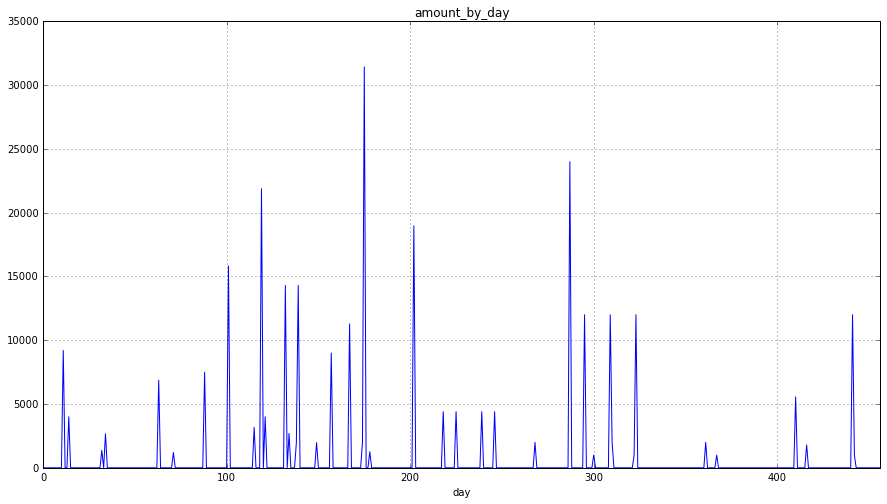

In [23]:
by_day.amount.plot(figsize=(15,8), grid=True, title="amount_by_day")

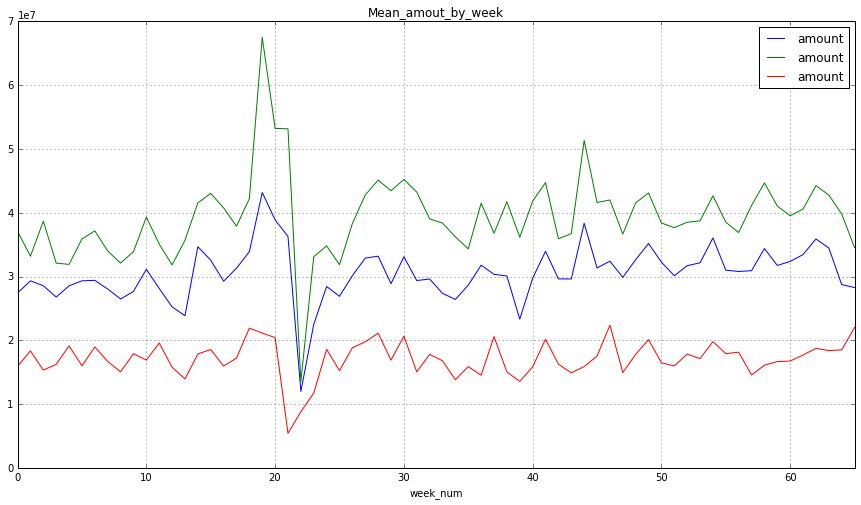

In [19]:
pd.concat([nalik.groupby("week_num").mean().amount, nalik.groupby("week_num").max().amount, nalik.groupby("week_num").min().amount], axis=1).plot(figsize=(15,8), grid=True, title="Mean_amout_by_week")

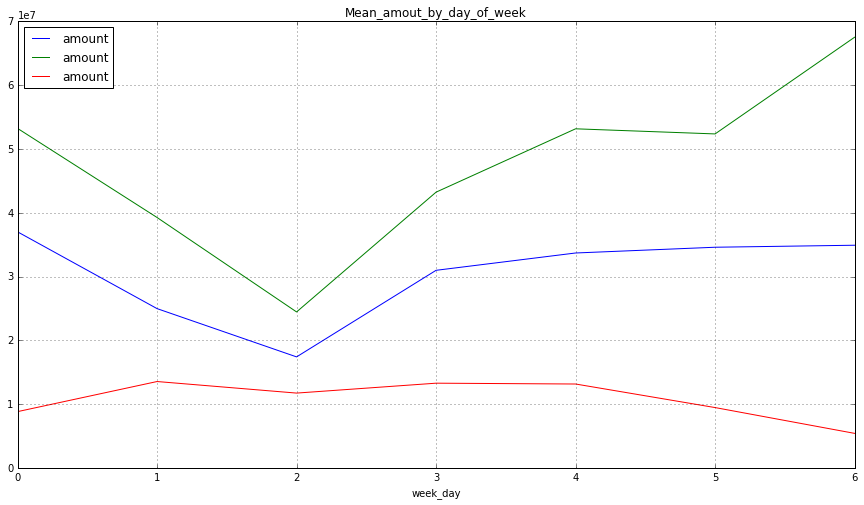

In [20]:
pd.concat([nalik.groupby("week_day").mean().amount, nalik.groupby("week_day").max().amount, nalik.groupby("week_day").min().amount], axis=1).plot(figsize=(15,8), grid=True, title="Mean_amout_by_day_of_week")

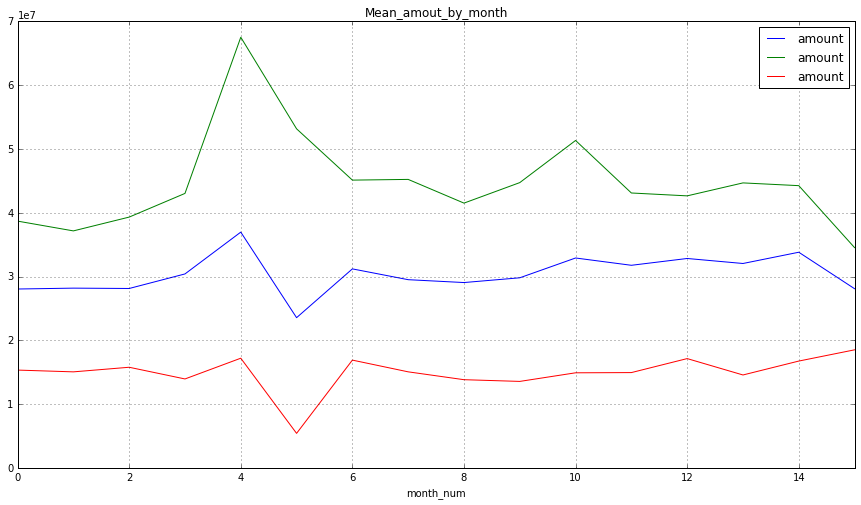

In [21]:
pd.concat([nalik.groupby("month_num").mean().amount, nalik.groupby("month_num").max().amount, nalik.groupby("month_num").min().amount], axis=1).plot(figsize=(15,8), grid=True, title="Mean_amout_by_month")

## Try ARMA?

In [22]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot


In [23]:
by_day = by_day.amount

In [55]:
by_day.index = pd.to_datetime(by_day.index, unit='D')

In [56]:
by_day.head()

day
1970-01-01    30724878.0
1970-01-02    18680505.0
1970-01-03    15929873.0
1970-01-04    29401266.0
1970-01-05    30840904.0
Name: amount, dtype: float64

In [30]:
%%time
arma_mod = sm.tsa.ARMA(by_day, (15,0)).fit()

CPU times: user 1min 2s, sys: 1.43 s, total: 1min 3s
Wall time: 33.8 s


In [57]:
#print(arma_mod.params)

In [32]:
predict_dynam = arma_mod.predict('1971-03-02', '1971-04-02', dynamic=True)

/Users/d.parpulov/anaconda/lib/python2.7/site-packages/statsmodels/base/data.py:503: FutureWarning: TimeSeries is deprecated. Please use Series
  return TimeSeries(result, index=self.predict_dates)


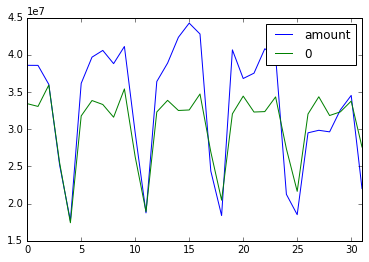

In [33]:
pd.concat([pd.DataFrame(by_day["1971-03-02":]).reset_index().drop(["day"], axis=1), pd.DataFrame(predict_dynam).reset_index().drop(["index"], axis=1)], axis=1).plot()

In [34]:
pred = np.array(pd.DataFrame(predict_dynam).reset_index().drop(["index"], axis=1)[0])

In [35]:
real = np.array(pd.DataFrame(by_day["1971-03-02":]).reset_index().drop(["day"], axis=1)["amount"])

In [36]:
def RMSLE(y_true,y_pred):
    return np.sqrt(np.sum(np.square(np.log(y_true + 500) - np.log(y_pred + 500)))/len(pred))

In [37]:
RMSLE(real, pred)

0.15772416532962338

In [42]:
data_mcc = pd.DataFrame(data=predict_dynam, columns=["volume"]).reset_index().drop(["index"], axis=1).head()

In [54]:
pd.concat([test_tr, data_mcc], axis=1)

,mcc_code,day,volume
0,6011,457,3.343335e+07
1,6011,458,3.306184e+07
2,6011,459,3.593463e+07
3,6011,460,2.550082e+07
4,6011,461,1.742744e+07
5,6011,462,NaN
6,6011,463,NaN
7,6011,464,NaN
8,6011,465,NaN
9,6011,466,NaN


In [44]:
mcc = 6011

In [52]:
test_tr = test_transactions[test_transactions.mcc_code == mcc][["mcc_code", "day"]].reset_index().drop(["index"], axis=1)

In [48]:
test_transactions[['mcc_code', 'day', 'volume']].head()

KeyError: "['volume'] not in index"

## ARIMA IN cycle

In [ ]:
test_transactions[['mcc_code', 'day', 'volume']].to_csv('baseline_b.csv', index=False)